The Supervised learning code of motorcycle crash analysis

In [2]:
import os
import pandas as pd
import json
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [7]:
# Load data
data = pd.read_excel('MotorBike_Accident_analysisUnclean.xlsx')
print('Data shape:', data.shape)
data = data.drop(columns = ['16. Any injury caused by motorcycle road traffic accidents over the last year? ( আপনি গত বছর কি মোটরসাইকেলজনিত কোন দুর্ঘটনায় আহত হয়েছিলেন?) '])
# Drop the column that allows the model to cheat and give high prediction accuracy

Data shape: (401, 30)


In [5]:
# split into training and test
print('Splitting into train/test (80/20)...')
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42) # Fix seed for reproducibility
train_df = train_df.drop([99, 182, 195, 257, 261, 313])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Separate features from labels
x_train = train_df.drop(columns = '15. Have you faced any road traffic accident over the last one year period? (আপনি কি গত এক বছরে কোন সড়ক দুর্ঘটনার মুখোমুখি হয়েছেন?) ')
y_train = train_df['15. Have you faced any road traffic accident over the last one year period? (আপনি কি গত এক বছরে কোন সড়ক দুর্ঘটনার মুখোমুখি হয়েছেন?) ']

Splitting into train/test (80/20)...


In [6]:
# Encode & impute training data
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
x_train_encoded = encoder.fit_transform(x_train)

# Impute missing values using RandomForestClassifier
imputer = IterativeImputer(estimator=RandomForestClassifier(), random_state=0)
x_train_encoded_imputed = imputer.fit_transform(x_train_encoded)

# Encode the labels
y_train_encoded = LabelEncoder().fit_transform(y_train)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(x_train_encoded_imputed, y_train_encoded)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Build missing-value table
missing_entries = []
for col in test_df.columns:
    for idx in test_df.index[test_df[col].isna()]:
        missing_entries.append({
            'column': col,
            'row_index': idx,
            'possible_values': []  # to fill manually
        })

missing_df = pd.DataFrame(missing_entries)

# After manually editing the missing values load them in again (I added this csv file with the upload of the assignment)
missing_df = pd.read_csv('missing_df.csv')
print(missing_df.head())
missing_df2 = missing_df.drop([0, 5]) # Drop the row that allows the model to cheat imputation

                                              column  row_index  \
0    8. Employment status ( আপনার চাকরির ধরণ কেমন?)           9   
1    8. Employment status ( আপনার চাকরির ধরণ কেমন?)          21   
2    8. Employment status ( আপনার চাকরির ধরণ কেমন?)          46   
3    8. Employment status ( আপনার চাকরির ধরণ কেমন?)          78   
4  14. Weekly working hours ( সপ্তাহে কত ঘণ্টা কা...         47   

                                     possible_values  
0                         ['Part-time', 'Full-time']  
1                         ['Part-time', 'Full-time']  
2                         ['Part-time', 'Full-time']  
3                         ['Part-time', 'Full-time']  
4  ['<40 hours', '>=60 hours', '>= 40 hours & <60...  


In [9]:
# Creating function for random imputation according to vectors
def random_impute_from_vectors(df, missing_df2):
    df_filled = copy.deepcopy(df)
    for _, row in missing_df2.iterrows():
        col, idx, vals = row['column'], row['row_index'], row['possible_values']
        if isinstance(vals, str):
            vals = eval(vals)
        if vals and len(vals) > 0:
            df_filled.loc[idx, col] = random.choice(vals)
    return df_filled

In [12]:
# Validate with N random imputations
results = []

for i in range(50):
    # Randomly impute test_df
    test_df_imputed = random_impute_from_vectors(test_df, missing_df2)

    x_test = test_df_imputed.drop(columns = '15. Have you faced any road traffic accident over the last one year period? (আপনি কি গত এক বছরে কোন সড়ক দুর্ঘটনার মুখোমুখি হয়েছেন?) ')
    y_test = test_df_imputed['15. Have you faced any road traffic accident over the last one year period? (আপনি কি গত এক বছরে কোন সড়ক দুর্ঘটনার মুখোমুখি হয়েছেন?) ']

    # Encode test data but only x_test
    x_test_encoded = encoder.transform(x_test)
    #test_imputed_df = pd.DataFrame(encoder.inverse_transform(encoded_test), columns=test_df.columns)
    
    y_test_encoded = LabelEncoder().fit_transform(y_test)

    # Predict and compute metrics
    y_pred = model.predict(x_test_encoded)
    acc = accuracy_score(y_test_encoded, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='weighted')
    
    results.append({
        'iteration': i+1,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    # Use jupyter to open results and view the validation of the model

/Users/gillesstevens/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2488 (\N{BENGALI LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gillesstevens/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gillesstevens/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2474 (\N{BENGALI LETTER PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gillesstevens/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2509 (\N{BENGALI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gillesstevens/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2468 (

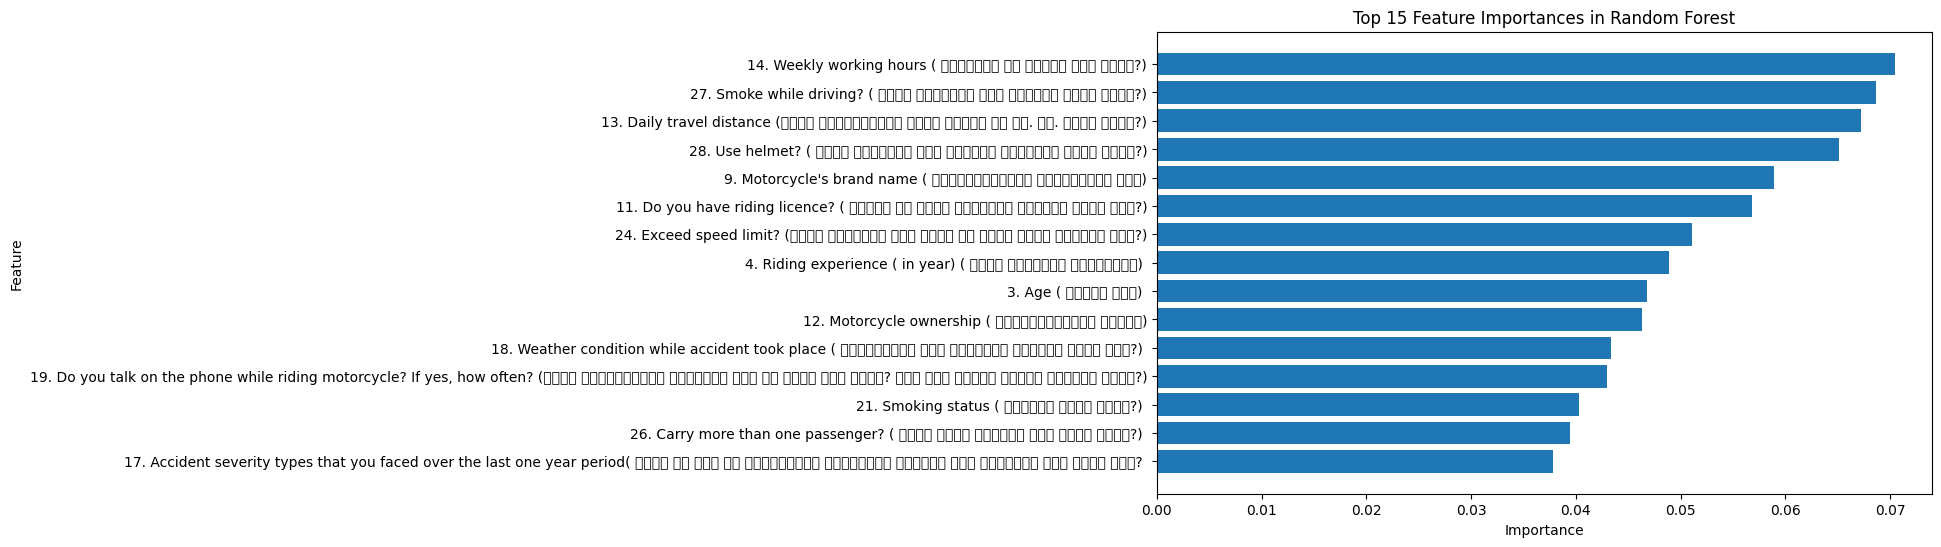

In [13]:
# Feature importance

importances = model.feature_importances_

features = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(features['Feature'][:15], features['Importance'][:15])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances in Random Forest')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(

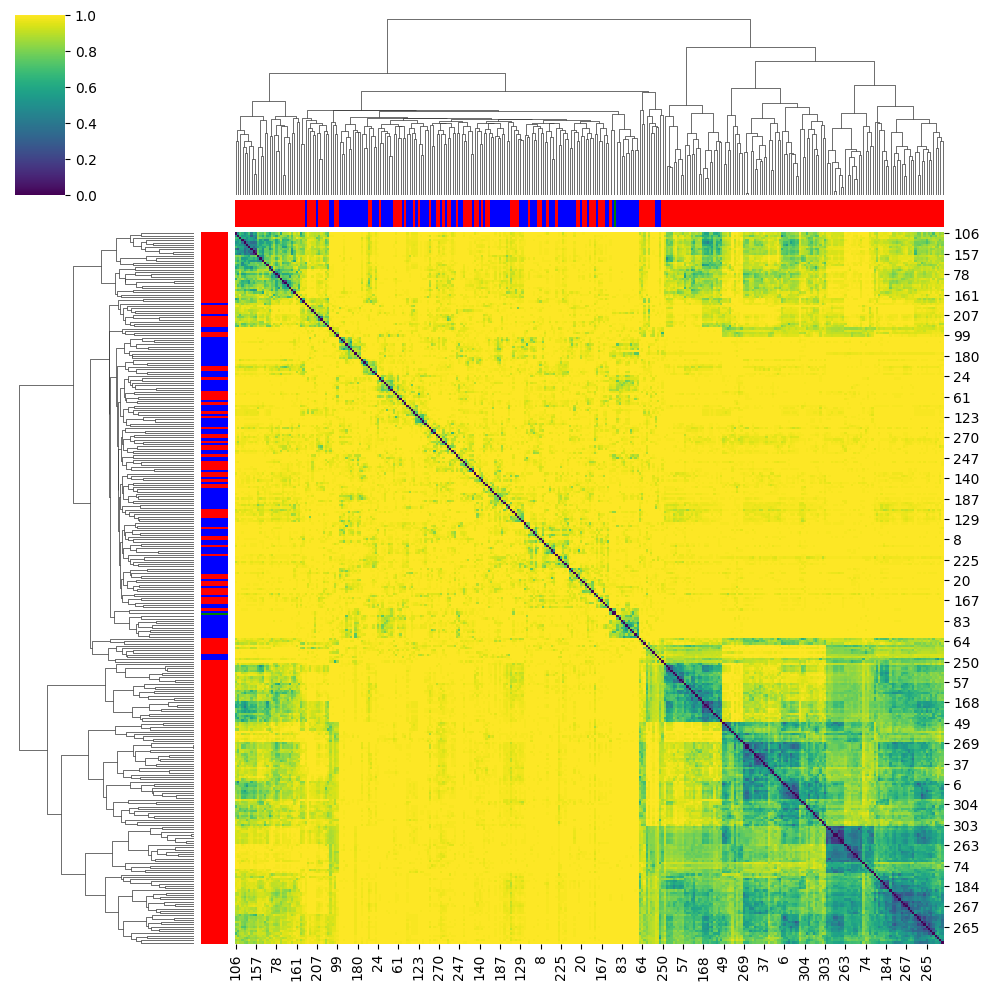

In [14]:
# Proximity matrix

def compute_proximity_matrix(model, X):
   
    # Get the leaf indices for each sample in each tree
    leaf_indices = model.apply(X)  # shape (n_samples, n_trees)

    n_samples = X.shape[0]
    n_trees = leaf_indices.shape[1]
    proximity = np.zeros((n_samples, n_samples))

    # For each tree, count how often samples share the same leaf
    for t in range(n_trees):
        leaves = leaf_indices[:, t]
        for leaf in np.unique(leaves):
            idx = np.where(leaves == leaf)[0]
            # Add 1 for all pairs in this leaf
            for i in idx:
                proximity[i, idx] += 1

    # Normalize by number of trees
    proximity = proximity / n_trees
    return proximity

proximity_matrix = compute_proximity_matrix(model, x_train_encoded_imputed)

colors = {0: 'blue', 1: 'red', 2: 'green'}
labelcolors = pd.Series(y_train_encoded).map(colors).to_numpy()
sns.clustermap(1 - proximity_matrix, cmap='viridis', row_colors=labelcolors, col_colors=labelcolors)
plt.show()